<a href="https://colab.research.google.com/github/jackysuenpython/Adam-Data-Science-Project-Deep-Learning-Consultant-for-Hospital-/blob/main/Optimizer_Adam_Data_Science_Project_Deep_Learning_Consultant_for_Hospital.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mission - Automate the process of detecting and classfying chest disease and reduce the cost and time of detection
#Data Science- Use X-RAY chest data to develop a model that could detect and classify the disease in less than 1 minute
#Data Info- 133 images that belong to 4 classes: Healthy, Covid-19, Bacterial Pneumonia, Viral Pneumonia
# Dataset Source:
# https://github.com/ieee8023/covid-chestxray-dataset
# https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [ ]:
#IMPORT LIBRARIES AND DATASET
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Specify training data directory
XRay_Directory = '/content/drive/My Drive/Datascience_Hospital_Project/Dataset'

In [ ]:
# List the folders in the directory
os.listdir(XRay_Directory)

['0', '3', '2', '1']

In [ ]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation
image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)

In [ ]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="training")


Found 428 images belonging to 4 classes.


In [ ]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="validation")

Found 104 images belonging to 4 classes.


In [ ]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [ ]:
#Check Train Image shape- if it fits our sample size
train_images.shape

(40, 256, 256, 3)

In [ ]:
#Check Train Label Shape if it fits our sample size
train_labels.shape

(40, 4)

In [ ]:
# labels Translator name the 4 different data
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

In [ ]:
#VISUALIZE DATASET

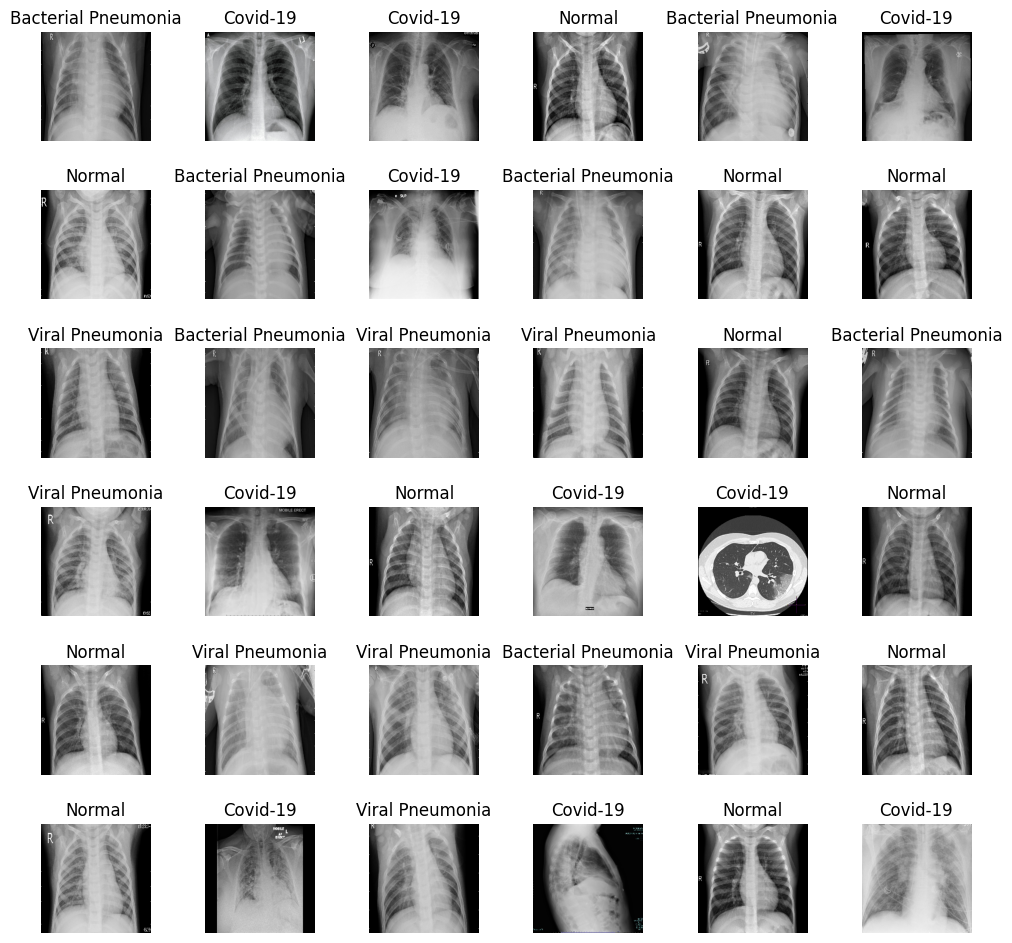

In [ ]:
# Create a grid of 36 images along with their corresponding labels
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

In [ ]:
#Use Deep Learning for machine learning- Detect and Classify
#For this project, I will use Convolution Neutral Networks
#First CNN layer is used to extract high level of general features, Last couple of layers are used to classify
#Local respective fields scan the image first searching for simple shapes (features), then these shapes are picked up by the subsequent layer to form more complex features
#As CNN grows deeper, vanishing gradient will occur to negatively impact network performance
#RESNET(Residual Network) will solve this problem, it includes skip connection feature which enable training of 152 layers without vanish graadient issues#
#RESENET works by adding identity mappings on top of CNN
#ImageNet contains 11 million images and 1100 categories
#ImageNet is used to train the RESENT deep network

In [ ]:
#After that i will use Transfer Learning to further validate the data input and output accuracy
#Transfer leaning is a machine learning technique in which a network that has been trained to perform a specific task is being reused as a starting point  for another similar task
#Transfer learning is widely used since starting from pre-trained model by other people can dramatically reduce time and effort require if trained from the start

In [ ]:
#IMPORT MODEL WITH PRETRAINED WEIGHTS
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
#freezing the model upto the last stage - 4 and re-training stage -5

for layer in basemodel.layers[:-10]:
  layers.trainable = False

In [ ]:
#BUILD AND TRAIN DEEP LEARNING MODEL
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(
    learning_rate=0.001,  # Recommended starting point
    beta_1=0.9,           # Default value for momentum decay
    beta_2=0.999,         # Default value for RMSprop decay
    epsilon=1e-7          # Small constant for numerical stability
)



In [ ]:
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',  # Or your desired loss function
    metrics=['accuracy']  # Or your preferred metrics
)

In [ ]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [ ]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 10, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

Epoch 1/10
107/107 [==============================] - ETA: 0s - loss: 1.6106 - accuracy: 0.4369
Epoch 1: val_loss improved from inf to 1.39703, saving model to weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107/107 [==============================] - 424s 4s/step - loss: 1.6106 - accuracy: 0.4369 - val_loss: 1.3970 - val_accuracy: 0.2500
Epoch 2/10
107/107 [==============================] - ETA: 0s - loss: 1.0119 - accuracy: 0.5958
Epoch 2: val_loss did not improve from 1.39703
107/107 [==============================] - 412s 4s/step - loss: 1.0119 - accuracy: 0.5958 - val_loss: 3.6170 - val_accuracy: 0.2500
Epoch 3/10
107/107 [==============================] - ETA: 0s - loss: 0.9633 - accuracy: 0.6472
Epoch 3: val_loss did not improve from 1.39703
107/107 [==============================] - 413s 4s/step - loss: 0.9633 - accuracy: 0.6472 - val_loss: 1.5073 - val_accuracy: 0.2500
Epoch 4/10
107/107 [==============================] - ETA: 0s - loss: 0.8185 - accuracy: 0.7033
Epoch 4: val_loss did not improve from 1.39703
107/107 [==============================] - 423s 4s/step - loss: 0.8185 - accuracy: 0.7033 - val_loss: 3.4901 - val_accuracy: 0.2500
Epoch 5/10
107/107 [=======================

In [ ]:
#EVALUATE TRAINED DEEP LEARNING MODEL

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

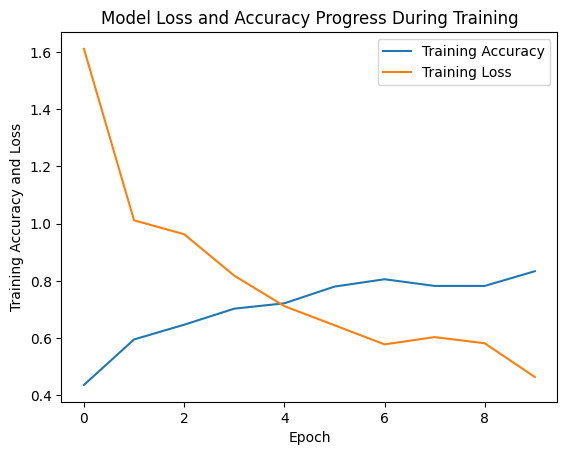

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])

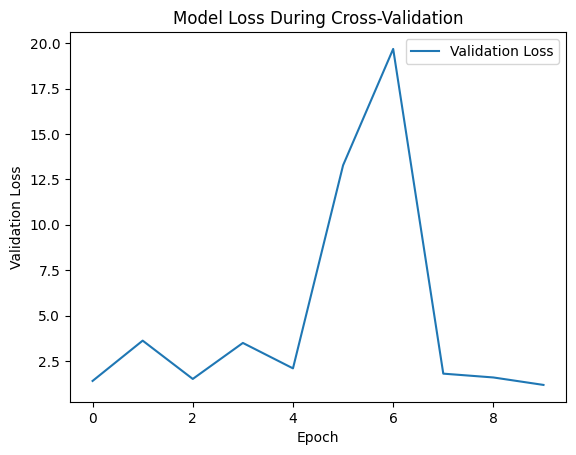

In [ ]:
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Loss'])

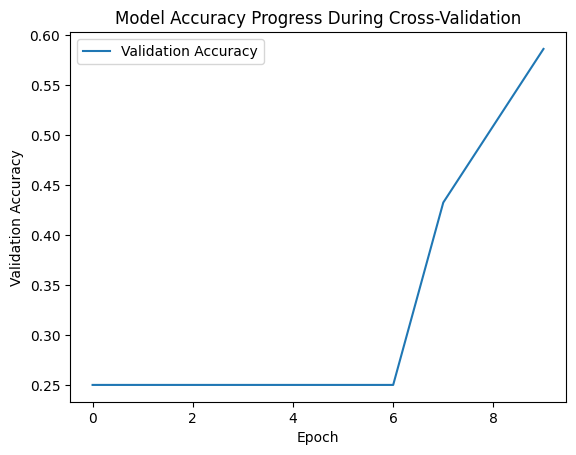

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

In [ ]:
test_directory = '/content/drive/My Drive/Datascience_Hospital_Project/Test'

In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.
 1/10 [==>...........................] - ETA: 2:06 - loss: 1.2608 - accuracy: 0.4750

10/10 [==============================] - 14s 17ms/step - loss: 1.2608 - accuracy: 0.4750
Accuracy Test : 0.4749999940395355


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 [==============================] - 0s 218ms/step


In [ ]:
len(original)

40

In [ ]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.425


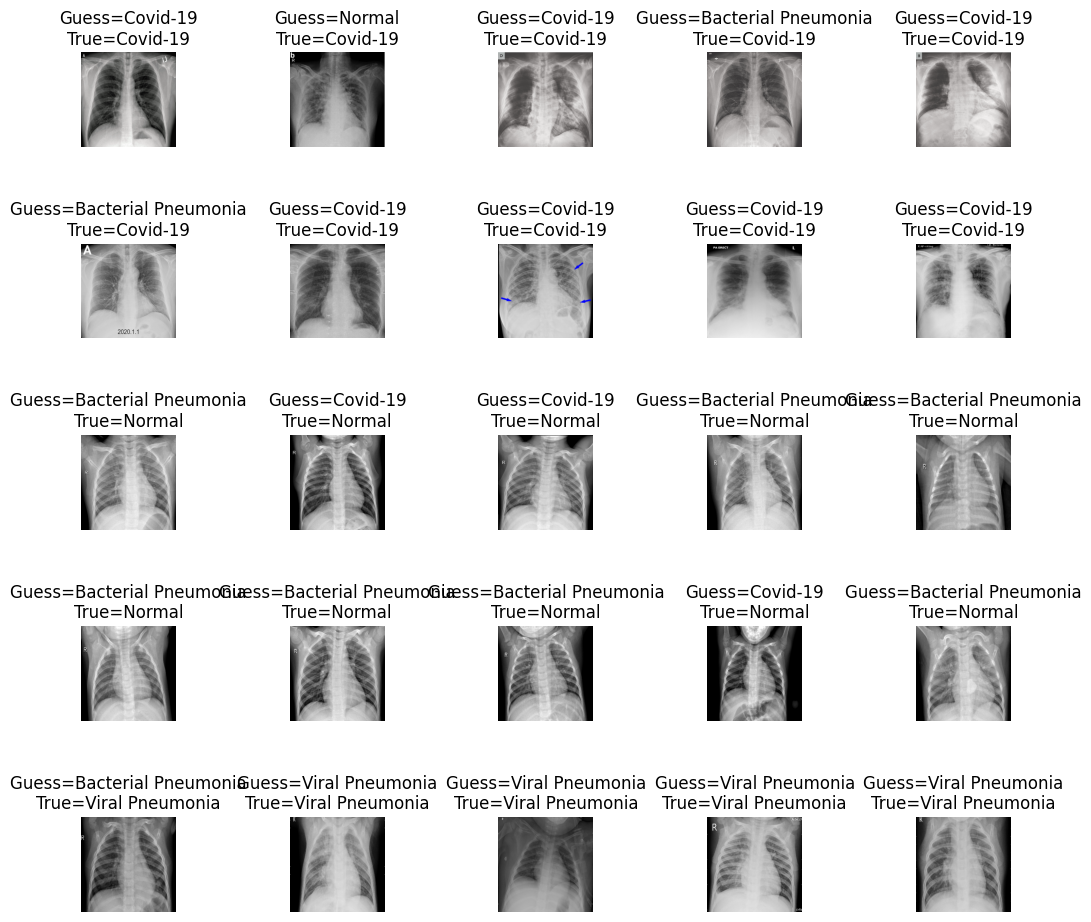

In [ ]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2)

In [ ]:
print(classification_report(np.asarray(original), np.asarray(prediction)))


              precision    recall  f1-score   support

           0       0.47      0.70      0.56        10
           1       0.00      0.00      0.00        10
           2       1.00      0.60      0.75        10
           3       0.25      0.40      0.31        10

    accuracy                           0.42        40
   macro avg       0.43      0.42      0.40        40
weighted avg       0.43      0.42      0.40        40



Text(0.5, 1.0, 'Confusion_matrix')

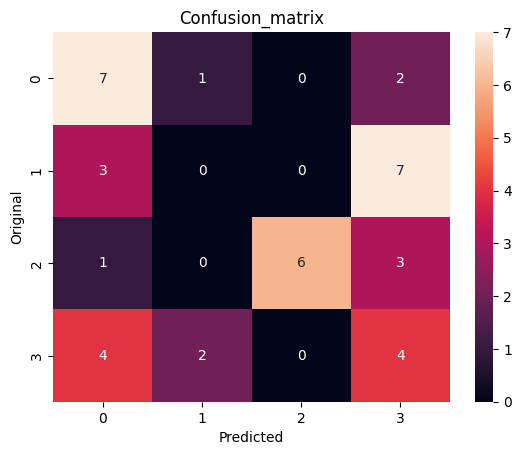

In [ ]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

# Confusion Matrix Visualization:

#The output will be a heatmap where:
#Rows represent the true class labels.
#Columns represent the predicted class labels.
#Cell color intensity indicates the frequency of a particular combination of true and predicted labels (darker means more frequent).
#Numeric annotations in cells show the exact counts.
#Purpose:
#The confusion matrix offers a visual representation of the model's errors, making it easier to understand its strengths and weaknesses across different classes.
#It helps identify patterns like:
#Which classes are often confused with each other.
#Whether the model tends to make certain types of errors (e.g., false positives or false negatives).